# Setup

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!wget -O images.zip https://files.slack.com/files-pri/TJRDXSH3L-FKMNSAEFK/download/images.zip?pub_secret=37264d575e

--2019-06-24 10:03:56--  https://files.slack.com/files-pri/TJRDXSH3L-FKMNSAEFK/download/images.zip?pub_secret=37264d575e
Resolving files.slack.com (files.slack.com)... 99.84.254.166
Connecting to files.slack.com (files.slack.com)|99.84.254.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19029399 (18M) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]  18.15M  31.6MB/s    in 0.6s    

2019-06-24 10:03:56 (31.6 MB/s) - ‘images.zip’ saved [19029399/19029399]



In [0]:
!unzip -qq images.zip

# Model Definitions
Based on Single-Shot-Detector built with the FastAI library - https://github.com/rohitgeo/singleshotdetector

In [0]:
from fastai.vision.data import ObjectCategoryList, ObjectItemList, imagenet_stats
from fastai.vision.image import ImageBBox
import torch


def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count


class SSDObjectCategoryList(ObjectCategoryList):
    "`ItemList` for labelled bounding boxes detected using SSD."
    def analyze_pred(self, pred, thresh=0.5, nms_overlap=0.1, ssd=None):
        # def analyze_pred(pred, anchors, grid_sizes, thresh=0.5, nms_overlap=0.1, ssd=None):
        b_clas, b_bb = pred
        a_ic = ssd._actn_to_bb(b_bb, ssd._anchors.cpu(), ssd._grid_sizes.cpu())
        conf_scores, clas_ids = b_clas[:, 1:].max(1)
        conf_scores = b_clas.t().sigmoid()

        out1, bbox_list, class_list = [], [], []

        for cl in range(1, len(conf_scores)):
            c_mask = conf_scores[cl] > thresh
            if c_mask.sum() == 0: 
                continue
            scores = conf_scores[cl][c_mask]
            l_mask = c_mask.unsqueeze(1)
            l_mask = l_mask.expand_as(a_ic)
            boxes = a_ic[l_mask].view(-1, 4) # boxes are now in range[ 0, 1]
            boxes = (boxes-0.5) * 2.0        # putting boxes in range[-1, 1]
            ids, count = nms(boxes.data, scores, nms_overlap, 50) # FIX- NMS overlap hardcoded
            ids = ids[:count]
            out1.append(scores[ids])
            bbox_list.append(boxes.data[ids])
            class_list.append(torch.tensor([cl]*count))

        if len(bbox_list) == 0:
            return None #torch.Tensor(size=(0,4)), torch.Tensor()

        return torch.cat(bbox_list, dim=0), torch.cat(class_list, dim=0) # torch.cat(out1, dim=0), 

    
    def reconstruct(self, t, x):
        if t is None: return None
        bboxes, labels = t
        if len((labels - self.pad_idx).nonzero()) == 0: return
        i = (labels - self.pad_idx).nonzero().min()
        bboxes,labels = bboxes[i:],labels[i:]
        return ImageBBox.create(*x.size, bboxes, labels=labels, classes=self.classes, scale=False)

    
class SSDObjectItemList(ObjectItemList):
    "`ItemList` suitable for object detection."
    _label_cls,_square_show_res = SSDObjectCategoryList,False

### Utility functions

In [0]:
import torch
from torch import nn
import torch.nn.functional as F

def conv_params(in_size, out_size):
    filters = [3,2,5,4]
    strides = [1,2,3] # max_stride = 3
    pads = [0,1,2,3] # max pad
    
    if out_size == 1:
        return 1, 0, in_size
    
    for filter_size in filters:
        for pad in pads:
            for stride in strides:
                if ((out_size - 1) * stride == (in_size - filter_size) + 2 * pad):
                    return stride, pad, filter_size
    return None, None, None

class StdConv(nn.Module):
    def __init__(self, nin, nout, filter_size=3, stride=2, padding=1, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, filter_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): 
        return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (num_classes)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSDHead(nn.Module):
    def __init__(self, grids, anchors_per_cell, num_classes, drop=0.3, bias=-4.):
        super().__init__()
        self.drop = nn.Dropout(drop)
        
        self.sconvs = nn.ModuleList([])
        self.oconvs = nn.ModuleList([])
        
        self.anc_grids = grids
        
        self._k = anchors_per_cell

        
        self.sconvs.append(StdConv(512, 256, stride=1, drop=drop))
        
        
        for i in range(len(grids)):
            
            if i == 0:
                stride, pad, filter_size = conv_params(7, grids[i]) # get '7' by base model
            else:
                stride, pad, filter_size = conv_params(grids[i-1], grids[i])
            
            if stride is None:
                print(grids[i-1], ' --> ', grids[i])
                raise Exception('cannot create model for specified grids')
                
            self.sconvs.append(StdConv(256, 256, filter_size, stride=stride, padding=pad, drop=drop))
            self.oconvs.append(OutConv(self._k, 256, num_classes=num_classes, bias=bias))
                
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconvs[0](x)
        out_classes = []
        out_bboxes = []
        for sconv, oconv in zip(self.sconvs[1:], self.oconvs):
            x = sconv(x)
            out_class, out_bbox = oconv(x)
            out_classes.append(out_class)
            out_bboxes.append(out_bbox)
            
        return [torch.cat(out_classes, dim=1),
                torch.cat(out_bboxes, dim=1)]

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = torch.Tensor(t[:,1:].contiguous()).cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/(self.num_classes-1)
    
    def get_weight(self,x,t): return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        w = w * (1-pt).pow(gamma)
        return w.detach()

### SingleShotDetector

In [0]:
import torch
from fastai.vision.learner import create_cnn
from torchvision.models import resnet34
import numpy as np
import json
import os
from pathlib import Path

class _EmptyData():
    def __init__(self, path, c, loss_func: None):
        self.path = path
        self.device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
        self.c = c
        self.loss_func = loss_func

class SingleShotDetector(object):
    
    def __init__(self, data, grids=[4, 2, 1], zooms=[0.7, 1., 1.3], ratios=[[1., 1.], [1., 0.5], [0.5, 1.]], 
                 backbone=None, drop=0.3, bias=-4., focal_loss=False, pretrained_path=None):
        
        super().__init__()

        self._device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')


        if backbone is None:
            backbone = resnet34
            
        self._create_anchors(grids, zooms, ratios)
        
        ssd_head = SSDHead(grids, self._anchors_per_cell, data.c, drop=drop, bias=bias)

        self._data = data
        self.learn = create_cnn(data=data, base_arch=backbone, custom_head=ssd_head)
        self.learn.model = self.learn.model.to(self._device)

        if pretrained_path is not None:
            self.load(pretrained_path)
        
        if focal_loss:
            self._loss_f = FocalLoss(data.c)
        else:
            self._loss_f = BCE_Loss(data.c)
            
        self.learn.loss_func = self._ssd_loss

    @classmethod
    def from_emd(cls, data, emd_path):
        emd = json.load(open(emd_path))
        class_mapping = {i['Value'] : i['Name'] for i in emd['Classes']}
        if data is None:
            empty_data = _EmptyData(path='str', loss_func=None, c=len(class_mapping) + 1)
            return cls(empty_data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])
        else:
            return cls(data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])

    
    def lr_find(self):
        from IPython.display import clear_output
        self.learn.lr_find()
        clear_output()
        self.learn.recorder.plot()
        
    def fit(self, epochs=10, lr=slice(1e-4,3e-3)):
        self.learn.fit(epochs, lr)

    def unfreeze():
        self.learn.unfreeze()
        
    def _create_anchors(self, anc_grids, anc_zooms, anc_ratios):
        
        self.grids = anc_grids
        self.zooms = anc_zooms
        self.ratios =  anc_ratios

        anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
        
        self._anchors_per_cell = len(anchor_scales)
        
        anc_offsets = [1/(o*2) for o in anc_grids]

        anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), self._anchors_per_cell, axis=0)

        anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])
        
        self._grid_sizes = torch.Tensor(np.concatenate([np.array([ 1/ag  for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])).unsqueeze(1).to(self._device)
        
        self._anchors = torch.Tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float().to(self._device)
        
        self._anchor_cnr = self._hw2corners(self._anchors[:,:2], self._anchors[:,2:])
        
    def _hw2corners(self, ctr, hw): 
        return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

    def _get_y(self, bbox, clas):
        bbox = bbox.view(-1,4) #/sz
        bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
        return bbox[bb_keep],clas[bb_keep]

    def _actn_to_bb(self, actn, anchors, grid_sizes):
        actn_bbs = torch.tanh(actn)
        actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
        actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
        return self._hw2corners(actn_centers, actn_hw)

    def _map_to_ground_truth(self, overlaps, print_it=False):
        prior_overlap, prior_idx = overlaps.max(1)
        if print_it: print(prior_overlap)
        gt_overlap, gt_idx = overlaps.max(0)
        gt_overlap[prior_idx] = 1.99
        for i,o in enumerate(prior_idx): gt_idx[o] = i
        return gt_overlap, gt_idx
        
        
    def _ssd_1_loss(self, b_c, b_bb, bbox, clas, print_it=False):
        bbox,clas = self._get_y(bbox,clas)
        bbox = self._normalize_bbox(bbox)

        a_ic = self._actn_to_bb(b_bb, self._anchors, self._grid_sizes)
        overlaps = self._jaccard(bbox.data, self._anchor_cnr.data)
        try:
            gt_overlap,gt_idx = self._map_to_ground_truth(overlaps,print_it)
        except Exception as e:
            return 0.,0.
        gt_clas = clas[gt_idx]
        pos = gt_overlap > 0.4
        pos_idx = torch.nonzero(pos)[:,0]
        gt_clas[1-pos] = 0 #data.c - 1 # CHANGE
        gt_bbox = bbox[gt_idx]
        loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
        clas_loss  = self._loss_f(b_c, gt_clas)
        return loc_loss, clas_loss
    
    def _ssd_loss(self, pred, targ1, targ2, print_it=False):
        lcs,lls = 0.,0.
        for b_c,b_bb,bbox,clas in zip(*pred, targ1, targ2):
            loc_loss,clas_loss = self._ssd_1_loss(b_c,b_bb,bbox.cuda(),clas.cuda(),print_it)
            lls += loc_loss
            lcs += clas_loss
        if print_it: print(f'loc: {lls}, clas: {lcs}') #CHANGE
        return lls+lcs
    
    def _intersect(self,box_a, box_b):
        max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
        min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
        inter = torch.clamp((max_xy - min_xy), min=0)
        return inter[:, :, 0] * inter[:, :, 1]

    def _box_sz(self, b): 
        return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

    def _jaccard(self, box_a, box_b):
        inter = self._intersect(box_a, box_b)
        union = self._box_sz(box_a).unsqueeze(1) + self._box_sz(box_b).unsqueeze(0) - inter
        return inter / union
    
    def _normalize_bbox(self, bbox): 
        return (bbox+1.)/2.

    
    
    def save(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai save to both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            if not os.path.exists(self.learn.path):
                os.makedirs(self.learn.path)            
            saved_path = self.learn.save(name, return_path=True)
            # undoing changes to self.learn.path and self.learn.model
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent
            if not os.path.exists(self.learn.path / self.learn.model_dir):
                os.makedirs(self.learn.path / self.learn.model_dir)            
            saved_path = self.learn.save(name_or_path,  return_path=True)
            # undoing changes to self.learn.path
            self.learn.path = temp

    def load(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai from both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            self.learn.load(name)
            # undoing changes to self.learn.path and self.learn.model_dir
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent            
            self.learn.load(name_or_path)
            # undoing changes to self.learn.path
            self.learn.path = temp
        
    def show_results(self, rows=5, thresh=0.5, nms_overlap=0.1):
        self.learn.show_results(rows=rows, thresh=thresh, nms_overlap=nms_overlap, ssd=self)

### Crater Data

In [0]:
bbox_filenames = [filename for filename in os.listdir('images') if filename.endswith('.txt') and filename != 'classes.txt']
len(bbox_filenames)

1446

In [0]:
from sklearn.model_selection import train_test_split

bbox_filenames_train, bbox_filenames_valid = train_test_split(bbox_filenames)
len(bbox_filenames_train), len(bbox_filenames_valid)

(1084, 362)

In [0]:
def get_category(num):
  if num == '0':
    return 'Crater'
  if num == '2':
    return 'Dark Dune'
  if num == '15':
    return 'Slope Streak'
  if num == '4':
    return 'Bright Dune'
  if num == '5':
    return 'Impact Ejecta'
  if num == '7':
    return 'Spider'
  return None

In [0]:
def get_voc_bbox(bb, w, h): 
  voc = []
  bbox_width = float(bb[2]) * w
  bbox_height = float(bb[3]) * h
  center_x = float(bb[1]) * w
  center_y = float(bb[0]) * h
  voc.append(center_x - (bbox_width / 2))
  voc.append(center_y - (bbox_height / 2))
  voc.append(center_x + (bbox_width / 2))
  voc.append(center_y + (bbox_height / 2))
  return voc

In [0]:
def get_img2bbox(bbox_filenames):
  img2bbox = {}
  for filename in bbox_filenames:
    with open('images/' + filename) as f:
      img_name = filename.split('.')[0] + '.jpg'
      img2bbox[img_name] = [[], []]
      
      lines = f.readlines()
      for line in lines:
        line_input = line.strip().split(' ')
        bbox = get_voc_bbox(list(map(float, line_input[1:])), w=227, h=227)
        category = get_category(line_input[0])
        img2bbox[img_name][0].append(bbox)
        img2bbox[img_name][1].append(category)
  return img2bbox

In [0]:
img2bbox = get_img2bbox(bbox_filenames_train)
img2bbox_v = get_img2bbox(bbox_filenames_valid)
def get_y_func(x):
    if x.name in img2bbox:
        bboxes, classes = img2bbox[x.name]
    else:
        bboxes, classes = img2bbox_v[x.name]
    return [bboxes, classes] 

In [0]:
bbox = img2bbox['ESP_011289_1950_RED-0146-fv.jpg'][0][0]
bbox

[132.9998675, 116.00006450000002, 159.9999285, 143.00012550000002]

In [0]:
import fastai
import numpy as np
import pandas as pd
from pathlib import Path

from fastai.vision.transform import get_transforms
from fastai.vision.data import ObjectItemList, imagenet_stats#, bb_pad_collate
from fastai import *
from fastai.vision import *

In [0]:
PATH = Path(r'images/')

In [0]:
data = (SSDObjectItemList.from_folder(PATH)
        .split_by_files(list(img2bbox_v.keys()))                          
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=64, collate_fn=bb_pad_collate)
        .normalize(imagenet_stats))

CPU times: user 1.44 s, sys: 798 ms, total: 2.24 s
Wall time: 3.21 s


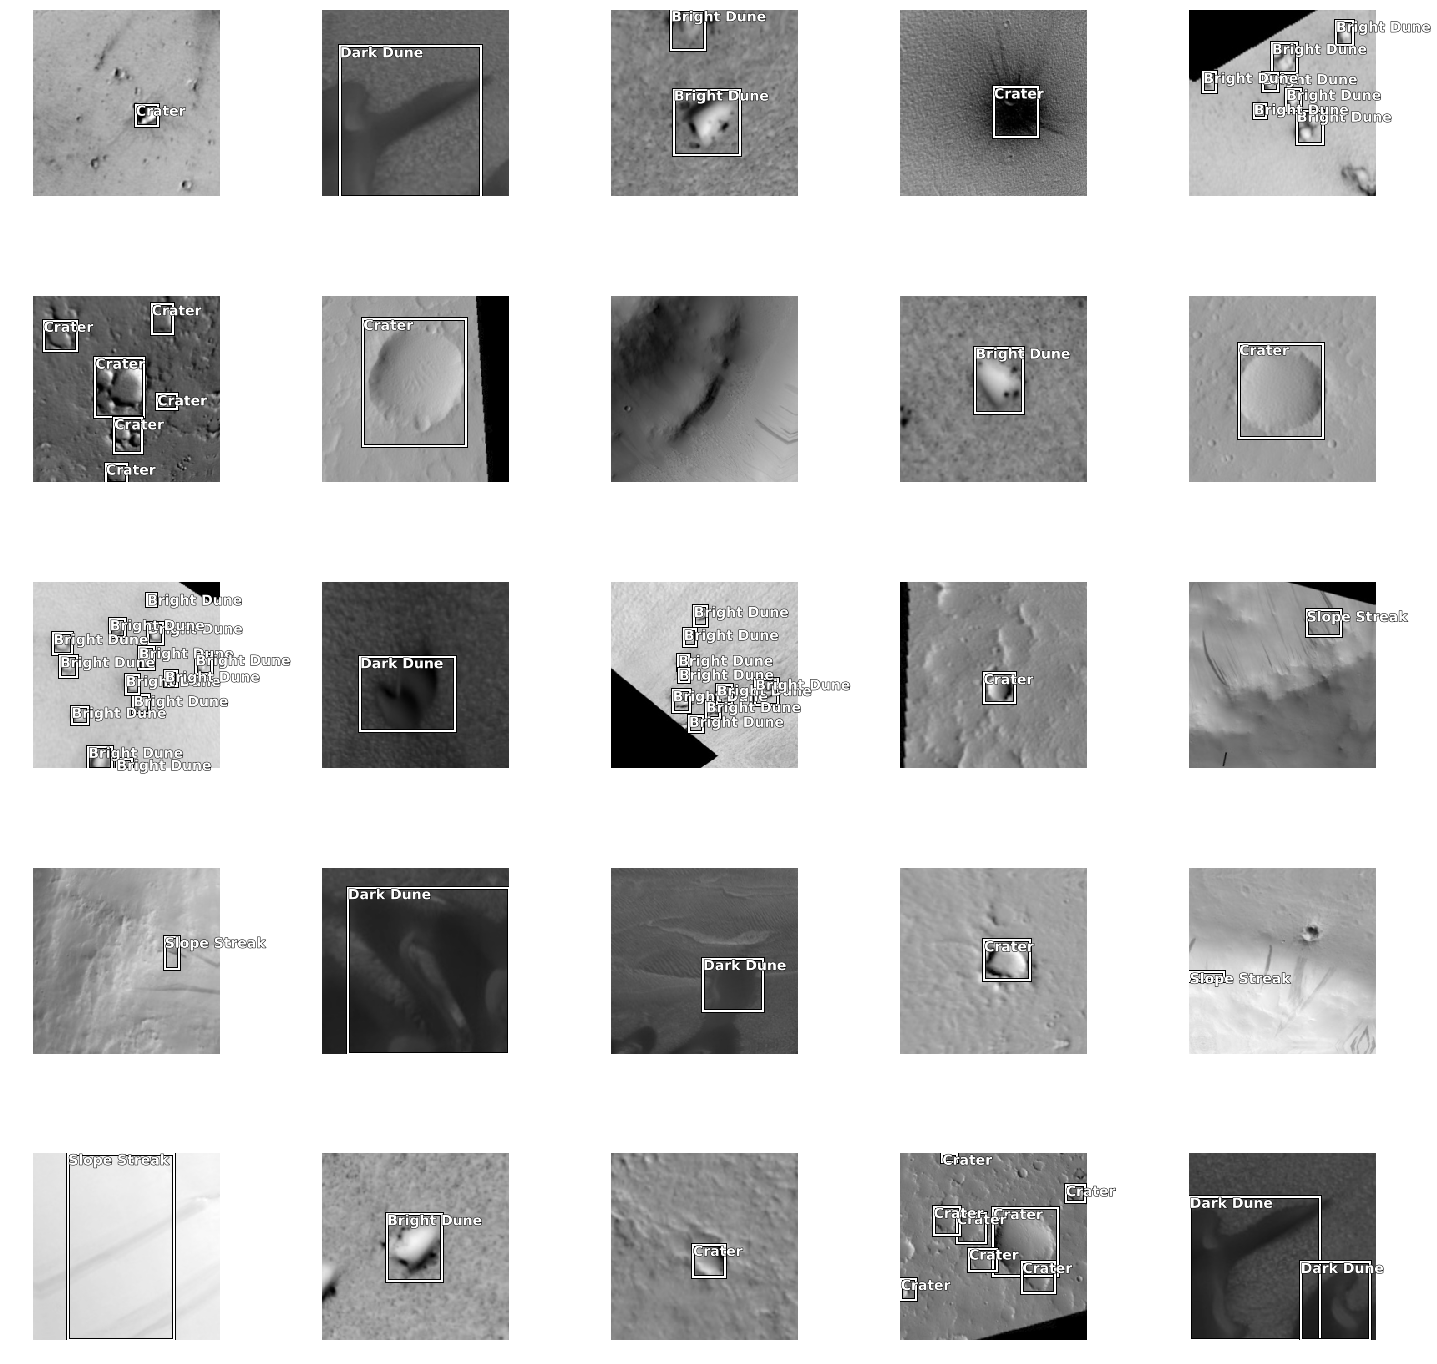

In [0]:
%%time
data.show_batch()

### SSD (Low Accuracy)

In [0]:
ssd = SingleShotDetector(data)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 126766471.45it/s]


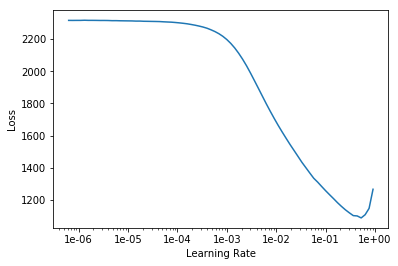

In [0]:
ssd.lr_find()

In [0]:
ssd.fit(20, lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,124.523575,63.104645,00:10
1,76.417572,54.888134,00:10
2,60.053623,53.795563,00:10
3,54.136360,67.906448,00:10
4,50.664368,137.109161,00:10
5,47.846638,47.337543,00:10
6,44.568382,52.956326,00:10
7,42.348209,48.636189,00:10
8,41.303055,44.745132,00:10
9,38.351051,46.932529,00:10


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [0]:
ssd.save('ssd-pascal-20')

In [0]:
ssd.load('ssd-pascal-20')

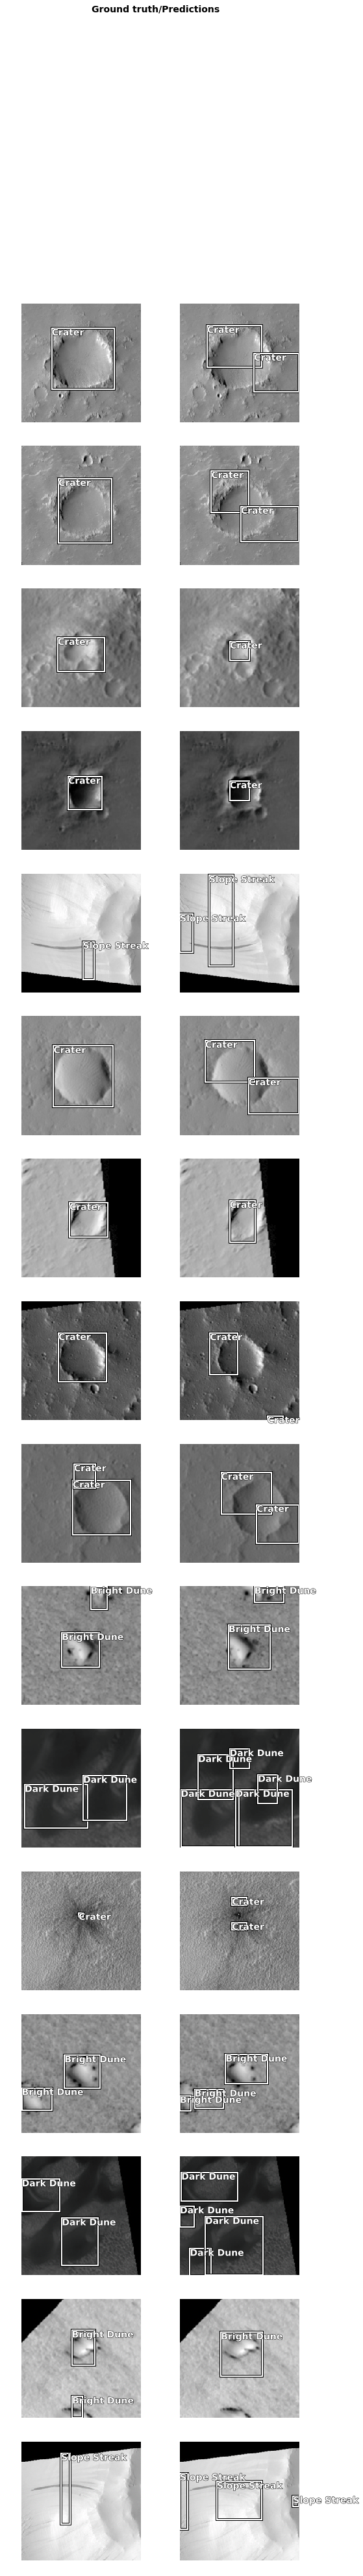

In [0]:
ssd.show_results(rows=64, thresh=0.1)

### Simple SSD (High Accuracy with Focal Loss)
4x4 grid with one anchor box per grid cell

In [0]:
simple_ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]], focal_loss=True)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


#### Train Model

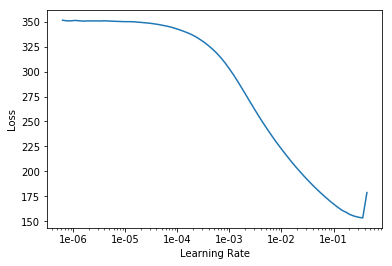

In [0]:
simple_ssd.lr_find()

In [0]:
simple_ssd.fit(30, lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,65.656342,34.631775,00:13
1,41.001141,19.882494,00:13
2,31.566923,16.977549,00:13
3,26.626125,15.988818,00:13
4,23.488546,15.090068,00:13
5,21.417234,14.860567,00:13
6,19.917200,14.654522,00:13
7,18.757809,14.699132,00:13
8,17.985933,13.990636,00:13
9,17.291935,13.970877,00:13


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


#### Load Saved Model

In [0]:
simple_ssd.learn.model.load_state_dict(torch.load('simple_ssd.pth'))
simple_ssd.learn.model.eval()

#### Show Results

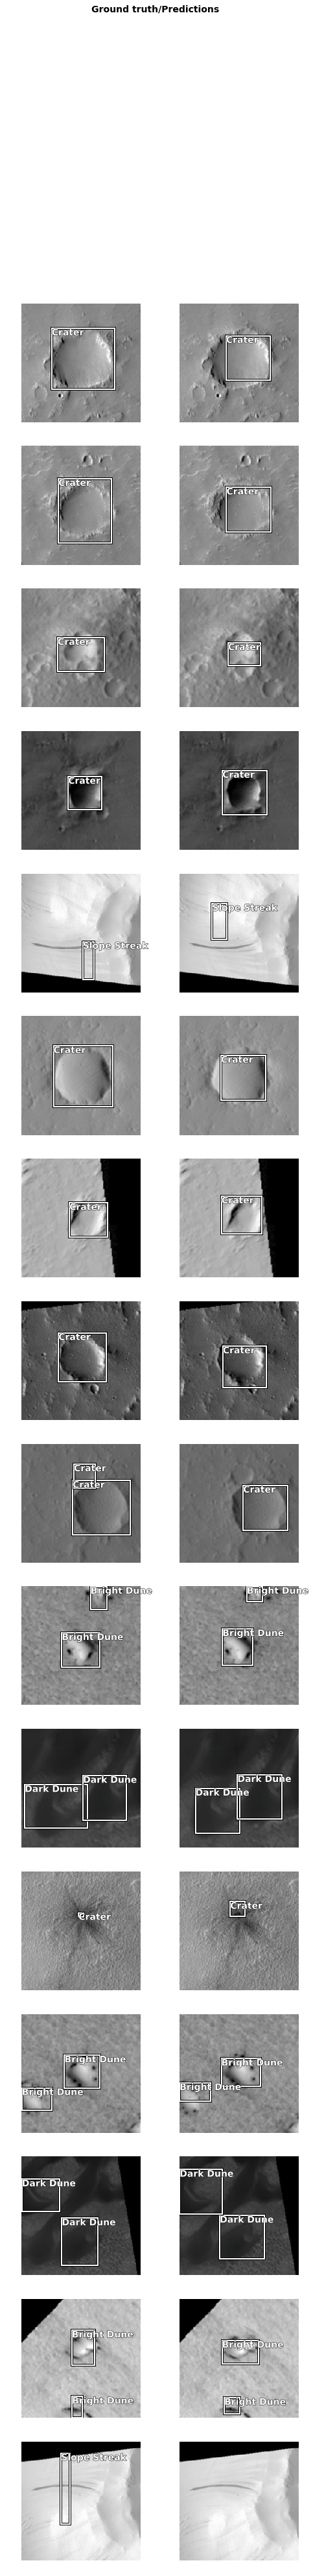

In [0]:
simple_ssd.show_results(rows=16, thresh=0.3)

## Save Model

In [0]:
torch.save(simple_ssd.learn.model.state_dict(), 'simple_ssd.pth')

In [0]:
simple_ssd.learn.model.load_state_dict(torch.load('simple_ssd.pth'))
simple_ssd.learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Feature Extraction Layers for Divyanshu

In [0]:
simple_ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]], focal_loss=True)

In [0]:
simple_ssd.learn.model.load_state_dict(torch.load('simple_ssd.pth'))
simple_ssd.learn.model.eval()

In [0]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [0]:
simple_ssd.learn.model[1] = Identity()

In [0]:
simple_ssd.learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
simple_ssd.learn.model(data.train_ds[0][0].px.unsqueeze(0).to(simple_ssd._device)).shape

torch.Size([1, 512, 7, 7])